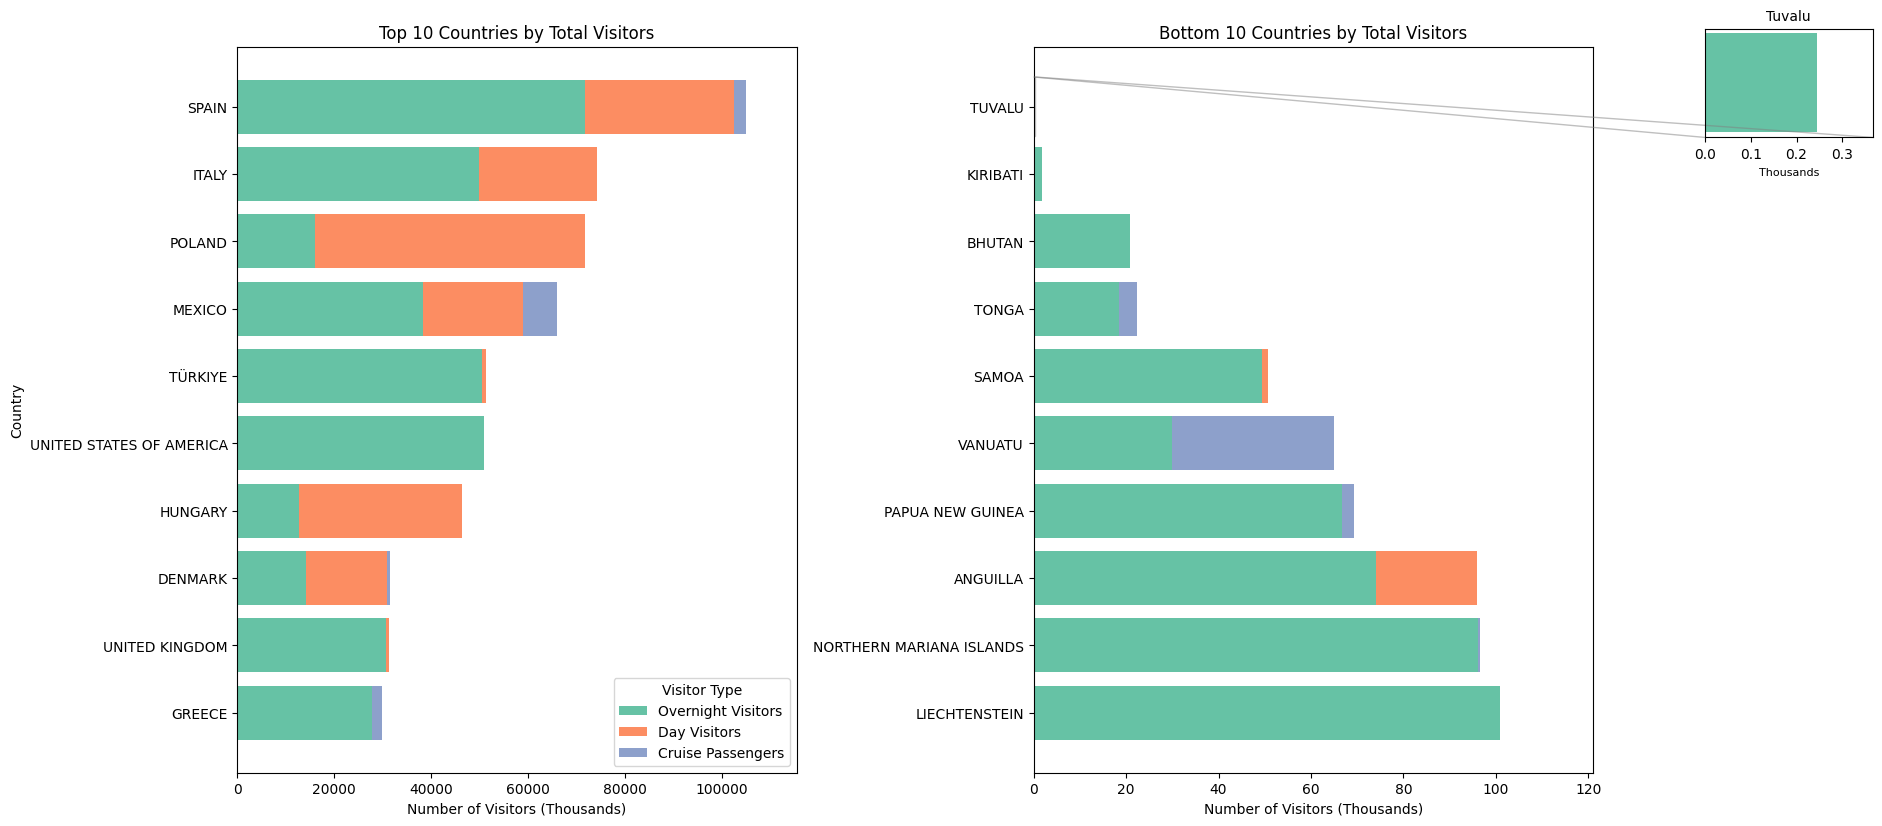

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Set Seaborn color scheme
sns.set_palette("Set2")
colors = sns.color_palette("Set2")
color_map = {
    'Overnight Visitors': colors[0],
    'Day Visitors': colors[1],
    'Cruise Passengers': colors[2]
}


# Load and process data
try:
    df = pd.read_csv('tourist_data_cleaned.csv', skipinitialspace=True)
except FileNotFoundError:
    print("Error: File not found. Ensure 'tourist_data_cleaned.csv' is in the correct directory.")
    exit()

# Process data into country-wise visitor categories
country_data = {}
current_country = None
visitor_data = {'Overnight': None, 'Day': None, 'Cruise': None}

for _, row in df.iterrows():
    if pd.notna(row['Country']):
        current_country = row['Country'].strip()
        country_data.setdefault(current_country, {})
    elif current_country:
        arrivals_info = str(row['Arrivals'])
        if 'Overnights visitors (tourists)' in arrivals_info:
            visitor_data['Overnight'] = row['2022']
        elif 'Same-day visitors (excursionists)' in arrivals_info:
            visitor_data['Day'] = row['2022']
        elif 'of which, cruise passengers' in arrivals_info:
            visitor_data['Cruise'] = row['2022']

        if all(visitor_data.values()):
            try:
                overnight = pd.to_numeric(str(visitor_data['Overnight']).replace('..', '0'), errors='coerce') or 0
                day = pd.to_numeric(str(visitor_data['Day']).replace('..', '0'), errors='coerce') or 0
                cruise = pd.to_numeric(str(visitor_data['Cruise']).replace('..', '0'), errors='coerce') or 0

                if overnight > 0 or day > 0 or cruise > 0:
                    country_data[current_country] = {
                        'Overnight Visitors': overnight,
                        'Day Visitors': day - cruise,
                        'Cruise Passengers': cruise,
                        'Total Visitors': overnight + day
                    }
            except ValueError as e:
                print(f"Warning: Could not process data for {current_country}: {e}")
            finally:
                visitor_data = {'Overnight': None, 'Day': None, 'Cruise': None}
                current_country = None

# Convert to DataFrame and filter
processed_df = pd.DataFrame.from_dict(country_data, orient='index')
processed_df.index.name = 'Country'
processed_df = processed_df[processed_df['Total Visitors'] > 0]
sorted_df = processed_df.sort_values(by='Total Visitors', ascending=False)

# Select top and bottom 10 countries
top_10 = sorted_df.head(10).copy()
bottom_10 = sorted_df.tail(10).copy()
tuvalu_data = bottom_10[bottom_10.index == 'TUVALU'][['Overnight Visitors', 'Day Visitors', 'Cruise Passengers']].copy()

# Melt DataFrames for plotting
def melt_df(df, columns):
    return df.reset_index().melt(
        id_vars='Country',
        value_vars=columns,
        var_name='Visitor Type',
        value_name='Number of Visitors'
    ).pivot_table(index='Country', columns='Visitor Type', values='Number of Visitors', fill_value=0)

visitor_types = ['Overnight Visitors', 'Day Visitors', 'Cruise Passengers']
# Ensure top_10_pivot is sorted by Total Visitors (descending)
top_10_pivot = melt_df(top_10, visitor_types)
top_10_pivot = top_10_pivot.loc[top_10.sort_values('Total Visitors', ascending=False).index]

# Ensure bottom_10_pivot is sorted by Total Visitors (ascending for bottom 10)
bottom_10 = bottom_10.sort_values('Total Visitors', ascending=True)  # Sort ascending for bottom 10
bottom_10_pivot = melt_df(bottom_10, visitor_types)
bottom_10_pivot = bottom_10_pivot.loc[bottom_10.index]  # Preserve the ascending order

tuvalu_pivot = melt_df(tuvalu_data, visitor_types)

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# Plot top 10 countries (highest at the top after invert_yaxis)
bottom = [0] * len(top_10_pivot)
for visitor_type in visitor_types:
    axes[0].barh(top_10_pivot.index, top_10_pivot[visitor_type], left=bottom, color=color_map[visitor_type], label=visitor_type)
    bottom += top_10_pivot[visitor_type]
axes[0].set_title('Top 10 Countries by Total Visitors')
axes[0].set_xlabel('Number of Visitors (Thousands)')
axes[0].set_ylabel('Country')
axes[0].invert_yaxis()
axes[0].legend(title='Visitor Type')
axes[0].set_xlim(0, top_10['Total Visitors'].max() * 1.1)  # Start x-axis at 0

# Plot bottom 10 countries (lowest at the bottom after invert_yaxis)
bottom = [0] * len(bottom_10_pivot)
for visitor_type in visitor_types:
    axes[1].barh(bottom_10_pivot.index, bottom_10_pivot[visitor_type], left=bottom, color=color_map[visitor_type], label=visitor_type)
    bottom += bottom_10_pivot[visitor_type]
axes[1].set_title('Bottom 10 Countries by Total Visitors')
axes[1].set_xlabel('Number of Visitors (Thousands)')
axes[1].set_ylabel('')
axes[1].invert_yaxis()
axes[1].set_xlim(0, bottom_10['Total Visitors'].max() * 1.2)  # Start x-axis at 0

# Inset for Tuvalu (positioned in the middle-right area of the bottom 10 plot)
inset_ax = inset_axes(axes[1], width="30%", height="15%", loc='center',
                      bbox_to_anchor=(0.85, 0.45, 1, 1), bbox_transform=axes[1].transAxes)

if not tuvalu_pivot.empty:
    bottom = [0] * len(tuvalu_pivot)
    for visitor_type in visitor_types:
        inset_ax.barh(tuvalu_pivot.index, tuvalu_pivot[visitor_type], left=bottom, color=color_map[visitor_type])
        bottom += tuvalu_pivot[visitor_type]
    inset_ax.invert_yaxis()
    inset_ax.set_xlabel('Thousands', fontsize=8)
    inset_ax.set_yticks([])
    inset_ax.set_title('Tuvalu', fontsize=10)
    inset_ax.set_xlim(0, tuvalu_pivot.sum(axis=1).max() * 1.5)  # Start x-axis at 0 for inset
    # Fix the mark_inset to point to TUVALU
    if 'TUVALU' in bottom_10_pivot.index:
        # Get the y-position of TUVALU in the bottom 10 plot
        tuvalu_idx = list(bottom_10_pivot.index).index('TUVALU')
        # Total number of bars in the bottom 10 plot
        num_bars = len(bottom_10_pivot.index)
        # Calculate the y-position (since bars are inverted, TUVALU's position needs adjustment)
        y_pos = num_bars - tuvalu_idx - 1  # Adjust for inversion
        # Use mark_inset to connect the TUVALU bar to the inset
        mark_inset(axes[1], inset_ax, loc1=3, loc2=4, fc="none", ec="0.5", alpha=0.5)
else:
    inset_ax.text(0.5, 0.5, 'No data for Tuvalu', ha='center', va='center', fontsize=10)
    inset_ax.axis('off')

# Save the plot instead of showing it
plt.savefig('tourist_data_plot.png')